In [1]:
import yfinance
import numpy as np
import pandas as pd

# Download Price Data

In [71]:
stock = yfinance.Ticker('AAPL')
prices = stock.history(period='day', start='2017-01-01', end='2021-12-31')

In [72]:
prices

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-01-03,27.137815,27.262020,26.894090,27.219837,115127600,0.0,0.0
2017-01-04,27.149530,27.304202,27.126095,27.189369,84472400,0.0,0.0
2017-01-05,27.165932,27.386222,27.140154,27.327635,88774400,0.0,0.0
2017-01-06,27.367478,27.690883,27.294830,27.632296,127007600,0.0,0.0
2017-01-09,27.641661,27.988500,27.639318,27.885386,134247600,0.0,0.0
...,...,...,...,...,...,...,...
2021-12-23,175.125322,176.121201,174.547711,175.553543,68356600,0.0,0.0
2021-12-27,176.360215,179.676494,176.340308,179.586868,74919600,0.0,0.0
2021-12-28,179.417573,180.582749,177.794285,178.551147,79144300,0.0,0.0


# Strategy
The strategy is to buy the stock at a low price and sell the stock at a high price.

### Calculating the base

Basicly, calculating the base backtest result when stock was brought at the current close price, then sold next day's close price. This means we have create a way to skip a day with our current dataset.

In [73]:
class Sim:
    def __init__(self):
        self.buy_at = 0
        self.is_holding = False
        self.results = []

    def play(self, data, a:str="Close", b:str="Close"):
        for d, row in data.iterrows():
            if not self.is_holding:
                self.buy_logic(row, a)
            else:
                self.sell_logic(row, b)
    
    def buy_logic(self, row, a):
        self.buy_at = row[a]
        self.is_holding = True
    
    def sell_logic(self, row, b):
        self.results.append(row[b] / self.buy_at - 1)
        self.is_holding = False

    def get_results(self):
        return pd.Series(self.results)

    def display_results(self):
        results = self.get_results()
        accum = (results + 1).prod()
        volatility = results.std()
        print(f"Accumulative result: {accum*100:.2f}%")
        print(f"Volatility: {volatility*100:.2f}%")
        results.hist(bins=100)

Accumulative result: 271.70%
Volatility: 1.76%


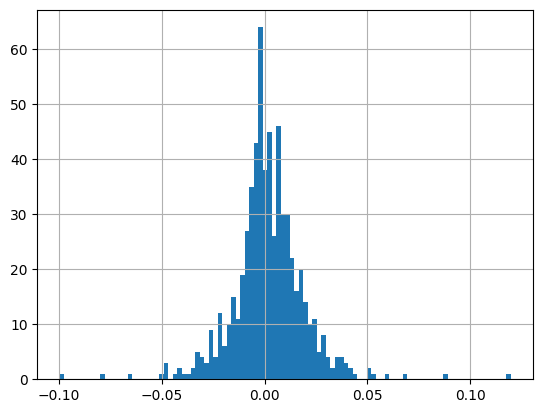

In [74]:
baseline = Sim()
baseline.play(prices, a="Close", b="Close")
baseline.display_results()

Accumulative result: 230009.74%
Volatility: 1.68%


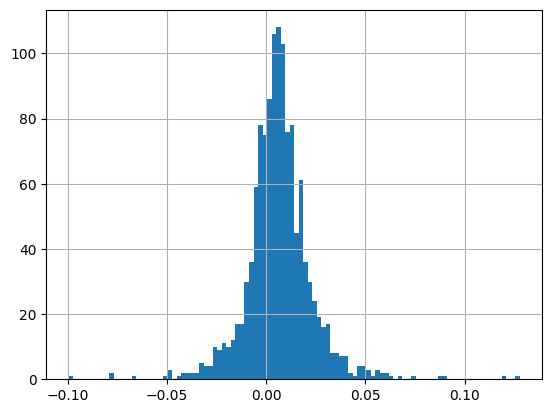

In [75]:
baseline.play(prices, a="Close", b="High")
baseline.display_results()

Accumulative result: 140776610259.02%
Volatility: 1.86%


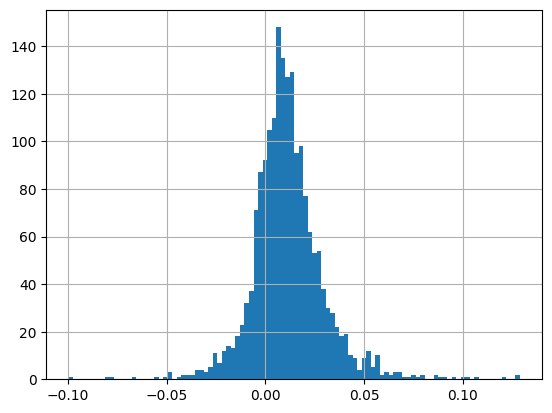

In [76]:
baseline.play(prices, a="Low", b="High")
baseline.display_results()

As we can see when change when to buy or sell can dramatically change the accumulative results.

### Trailing High

One way to adopt the above result is to use a kind of trailing limit to sell the stock at an given percentage below the high.

In [77]:
class TrailingHigh(Sim):
    def __init__(self, pct:float):
        super().__init__()
        self.pct = pct
    
    def buy_logic(self, row, a):
        self.buy_at = row[a]
        self.is_holding = True
    
    def sell_logic(self, row, b):
        sell_price = row.High * (1 - self.pct)
        if row.Low < sell_price < row.High:
            sell_at = sell_price / self.buy_at - 1
        else:
            sell_at = row.Close / self.buy_at - 1
        self.results.append(sell_at)
        self.is_holding = False

Accumulative result: 660.49%
Volatility: 1.44%


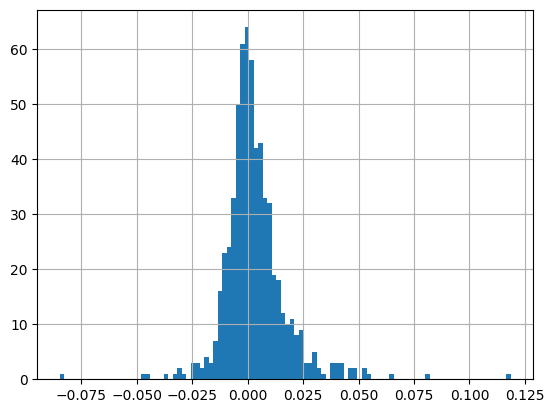

In [78]:
trailing_high = TrailingHigh(.008)
trailing_high.play(prices)
trailing_high.display_results()